### ISIC 2018 Skin Lesion Classification - EfficientNet B1



In [2]:
# ============================================================
# CELL 1: Mount Google Drive
# ============================================================
print("=" * 60)
print("CELL 1: MOUNT GOOGLE DRIVE")
print("=" * 60)

from google.colab import drive
drive.mount('/content/drive')

import os
DRIVE_ROOT = "/content/drive/MyDrive/ISIC_2018"

if os.path.exists(DRIVE_ROOT):
    print(f"✓ Found project folder: {DRIVE_ROOT}")
    print(f"  Contents: {os.listdir(DRIVE_ROOT)}")
else:
    print(f"❌ Project folder NOT found: {DRIVE_ROOT}")
    print("  Please create this folder and upload your dataset!")


CELL 1: MOUNT GOOGLE DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Found project folder: /content/drive/MyDrive/ISIC_2018
  Contents: ['Validation_Input', 'Test_Input', 'GroundTruth', 'Training_Input.csv', 'Training_Input', 'requirements.txt', 'src', 'outputs', '.ipynb_checkpoints', 'main.ipynb', '=0.9.0']


In [3]:
# ============================================================
# CELL 2: Install Dependencies & Check GPU
# ============================================================
print("\n" + "=" * 60)
print("CELL 2: INSTALL DEPENDENCIES & CHECK GPU")
print("=" * 60)

# Install required packages (most are pre-installed on Colab)
print("\n Installing required packages...")
!pip install -q timm>=0.9.0 tqdm scikit-learn seaborn pillow

print("✓ Packages installed!")

# Check GPU
import torch
print(f"\n System Info:")
print(f"  PyTorch version: {torch.__version__}")
print(f"  CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    !nvidia-smi
else:
    print("\n WARNING: No GPU detected! Training will be slow on CPU.")
    print("  Go to Runtime > Change runtime type > GPU")



CELL 2: INSTALL DEPENDENCIES & CHECK GPU

 Installing required packages...
✓ Packages installed!

 System Info:
  PyTorch version: 2.9.0+cpu
  CUDA available: False

  Go to Runtime > Change runtime type > GPU


In [4]:
# ============================================================
# CELL 3: Setup Python Path & Import Modules
# ============================================================
print("\n" + "=" * 60)
print("CELL 3: SETUP PYTHON PATH & IMPORT MODULES")
print("=" * 60)

import sys
import os

# Add src folder to Python path
DRIVE_ROOT = "/content/drive/MyDrive/ISIC_2018"
SRC_PATH = os.path.join(DRIVE_ROOT, "src")

if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)
    print(f"✓ Added to Python path: {SRC_PATH}")

# Verify src folder
if os.path.exists(SRC_PATH):
    print(f"✓ src folder found!")
    print(f"  Files: {os.listdir(SRC_PATH)}")
else:
    print(f" src folder NOT found at: {SRC_PATH}")
    print("  Please upload your src folder to Google Drive!")

# Import custom modules
import warnings
warnings.filterwarnings('ignore')

import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from config import *
from data_processing import load_all_data
from dataset import ISICDataset
from transforms import get_train_transform, get_val_transform
from model import build_model, count_parameters, load_checkpoint, save_checkpoint, print_model_info
from train import train_one_epoch, create_dataloaders, get_optimizer, get_scheduler, get_criterion
from evaluate import evaluate, plot_confusion_matrix, print_classification_report, create_submission, visualize_predictions
from visualize_dataset import plot_dataset_overview, plot_class_distribution_comparison

# Set random seed
set_seed(SEED)

# Print configuration
print_config()

print(f"\n✓ All modules imported successfully!")



CELL 3: SETUP PYTHON PATH & IMPORT MODULES
✓ Added to Python path: /content/drive/MyDrive/ISIC_2018/src
✓ src folder found!
  Files: ['__pycache__', 'data_processing.py', '__init__.py', 'config.py', 'engine.py', 'dataset.py', 'model.py', 'train.py', 'transforms.py', 'evaluate.py', 'visualize_dataset.py', '.ipynb_checkpoints']
✓ Running on Google Colab
✓ Drive Root: /content/drive/MyDrive/ISIC_2018
CONFIGURATION
Environment: Google Colab
Device: cpu
Random Seed: 42

Model: efficientnet_b1
Input Size: 224x224
Number of Classes: 7

Batch Size: 16
Learning Rate: 0.001
Weight Decay: 0.001
Number of Epochs: 5
Early Stop Patience: 2

Train CSV: /content/drive/MyDrive/ISIC_2018/GroundTruth/Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
Val CSV: /content/drive/MyDrive/ISIC_2018/GroundTruth/Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
Test CSV: /content/drive/MyDrive/ISIC_2018/GroundTruth/Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv

Train Images: /cont


CELL 4: LOAD AND VISUALIZE DATASET

LOADING DATA

=== TRAIN DATASET ===
Total samples: 10015

Label distribution:
  AKIEC: 327 (3.27%)
  BCC: 514 (5.13%)
  BKL: 1099 (10.97%)
  DF: 115 (1.15%)
  MEL: 1113 (11.11%)
  NV: 6705 (66.95%)
  VASC: 142 (1.42%)

=== VAL DATASET ===
Total samples: 193

Label distribution:
  AKIEC: 8 (4.15%)
  BCC: 15 (7.77%)
  BKL: 22 (11.40%)
  DF: 1 (0.52%)
  MEL: 21 (10.88%)
  NV: 123 (63.73%)
  VASC: 3 (1.55%)

=== TEST DATASET ===
Total samples: 1512

Label distribution:
  AKIEC: 43 (2.84%)
  BCC: 93 (6.15%)
  BKL: 217 (14.35%)
  DF: 44 (2.91%)
  MEL: 171 (11.31%)
  NV: 909 (60.12%)
  VASC: 35 (2.31%)

=== LABEL MAPPING ===
Number of classes: 7
  0: AKIEC
  1: BCC
  2: BKL
  3: DF
  4: MEL
  5: NV
  6: VASC

=== CLASS IMBALANCE ANALYSIS ===
Class imbalance ratio: 58.30
Max class count: 6705
Min class count: 115
High class imbalance detected (ratio > 3.0).
   Will use WeightedRandomSampler for balanced training.

DATA LOADING COMPLETE

 Generating dataset 

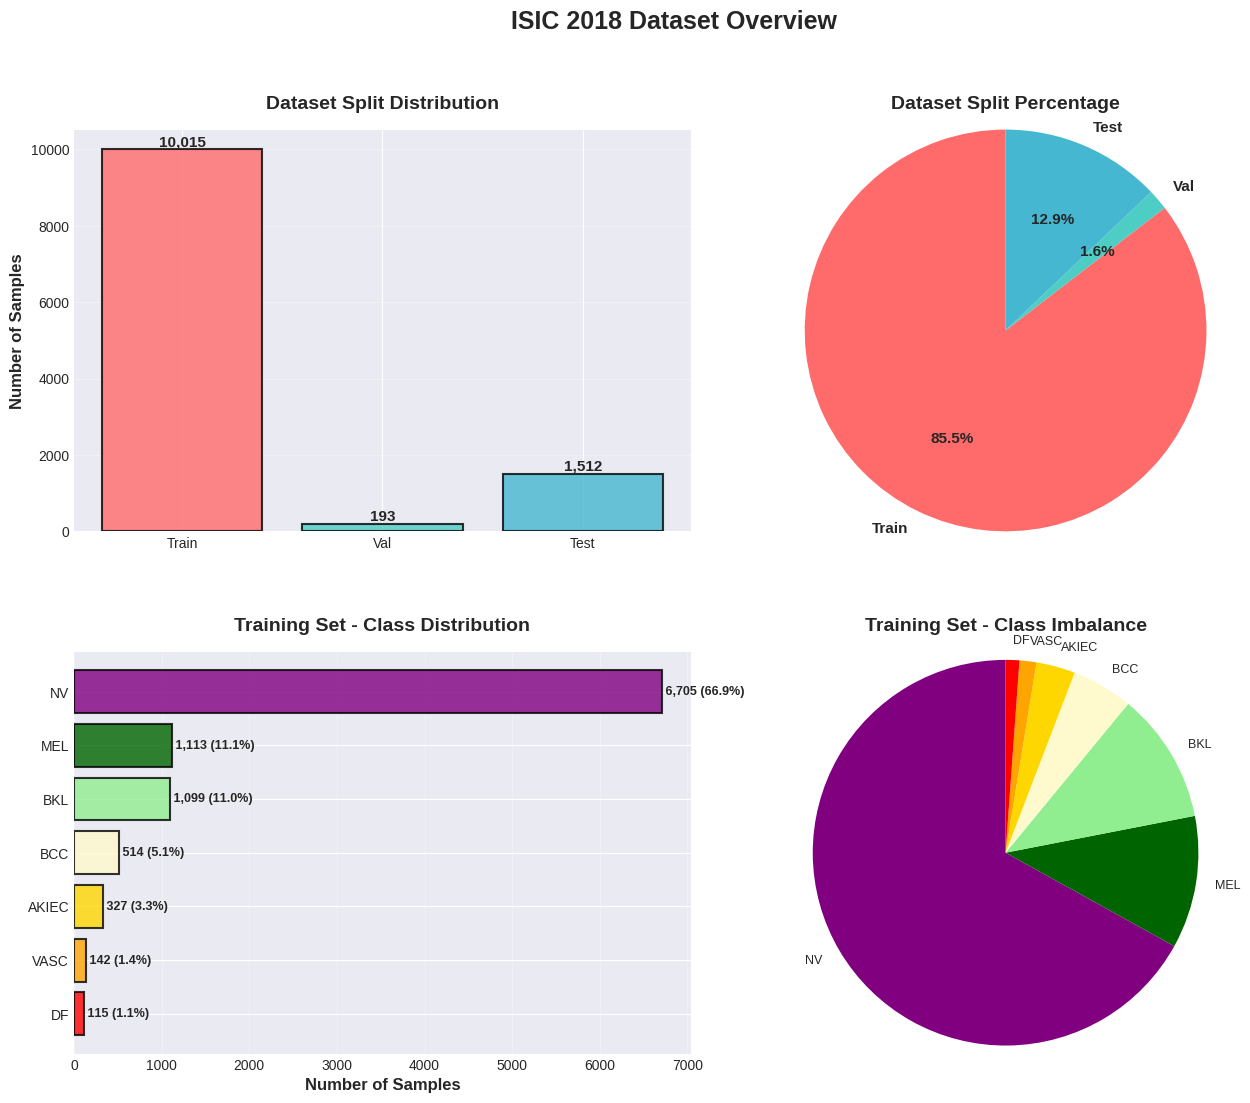

✅ Figure saved to: /content/drive/MyDrive/ISIC_2018/outputs/figures/class_distribution.png


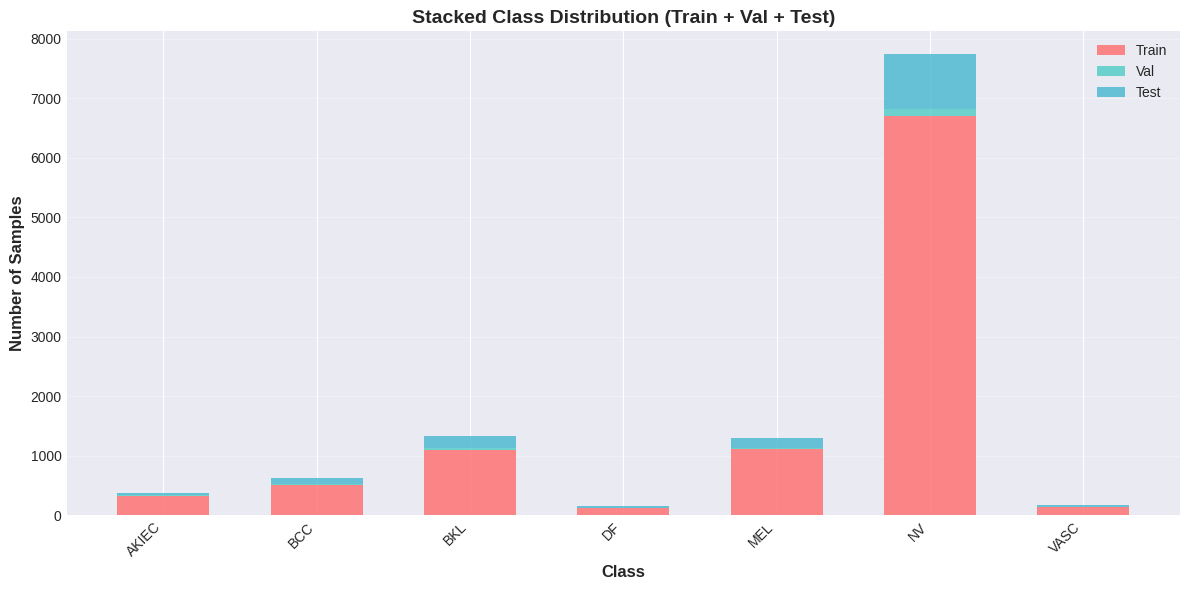


✓ Visualizations saved to: /content/drive/MyDrive/ISIC_2018/outputs/figures


In [5]:

# ============================================================
# CELL 4: Load and Visualize Dataset
# ============================================================
print("\n" + "=" * 60)
print("CELL 4: LOAD AND VISUALIZE DATASET")
print("=" * 60)

# Load all data
df_train, df_val, df_test, label2idx, idx2label, num_classes, use_weighted_sampler = load_all_data(
    PATH_TRAIN_CSV, PATH_VAL_CSV, PATH_TEST_CSV,
    DIR_TRAIN_IMG, DIR_VAL_IMG, DIR_TEST_IMG
)

# Store label mappings
LABEL2IDX = label2idx
IDX2LABEL = idx2label

# Visualize dataset
print("\n Generating dataset visualizations...")
fig1 = plot_dataset_overview(df_train, df_val, df_test,
                              save_path=os.path.join(DIR_FIGURES, "dataset_overview.png"))
plt.show()

fig2 = plot_class_distribution_comparison(df_train, df_val, df_test,
                                          save_path=os.path.join(DIR_FIGURES, "class_distribution.png"))
plt.show()

print(f"\n✓ Visualizations saved to: {DIR_FIGURES}")



In [6]:

# ============================================================
# CELL 5: Create Datasets and DataLoaders
# ============================================================
print("\n" + "=" * 60)
print("CELL 5: CREATE DATASETS AND DATALOADERS")
print("=" * 60)

# Create transforms
train_transform = get_train_transform()
val_transform = get_val_transform()

# Create datasets
train_dataset = ISICDataset(df_train, transform=train_transform)
val_dataset = ISICDataset(df_val, transform=val_transform)
test_dataset = ISICDataset(df_test, transform=val_transform)

print(f"\n✓ Datasets created:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    df_train, df_val, df_test,
    train_dataset, val_dataset, test_dataset,
    BATCH_SIZE, NUM_WORKERS, use_weighted_sampler
)

print(f"\n✓ Dataloaders created:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")




CELL 5: CREATE DATASETS AND DATALOADERS

✓ Datasets created:
  Train: 10015 samples
  Val: 193 samples
  Test: 1512 samples
Created WeightedRandomSampler for balanced training

DATA LOADERS
Batch size: 16
Num workers: 0
Train batches: 626
Val batches: 13
Test batches: 95

✓ Dataloaders created:
  Train: 626 batches
  Val: 13 batches
  Test: 95 batches


In [7]:
# ============================================================
# CELL 6: Build Model (Transfer Learning)
# ============================================================
print("\n" + "=" * 60)
print("CELL 6: BUILD MODEL (TRANSFER LEARNING)")
print("=" * 60)

# Build model with frozen backbone for transfer learning
print(f"\n🔧 Training Mode: {'Transfer Learning (frozen backbone)' if FREEZE_BACKBONE else 'Full Training'}")

model = build_model(
    num_classes=num_classes,
    pretrained=True,
    model_name=MODEL_NAME,
    drop_rate=DROP_RATE,
    drop_path_rate=DROP_PATH_RATE,
    freeze_backbone=FREEZE_BACKBONE  # Freeze backbone for transfer learning
)
model = model.to(DEVICE)

# Print model info
print_model_info(model, MODEL_NAME.upper())

# Setup training components
optimizer = get_optimizer(model, LEARNING_RATE, WEIGHT_DECAY)
scheduler = get_scheduler(optimizer, NUM_EPOCHS, USE_COSINE_SCHEDULER)
criterion = get_criterion(USE_LABEL_SMOOTHING, LABEL_SMOOTHING)

# Initialize tracking - Fresh start
history = {
    'epoch': [], 'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_bal_acc': [], 'lr': []
}
best_val_f1 = 0.0
best_epoch = 0
start_epoch = 0

# Check for existing checkpoint (optional resume)
if os.path.exists(MODEL_PATH):
    print(f"\n🔄 Found existing checkpoint: {MODEL_PATH}")
    try:
        checkpoint = load_checkpoint(model, optimizer, MODEL_PATH, DEVICE)
        start_epoch = checkpoint.get('epoch', 0)
        best_val_f1 = checkpoint.get('best_val_f1', 0.0)
        best_epoch = checkpoint.get('best_epoch', 0)
        if 'history' in checkpoint:
            history = checkpoint['history']
        print(f"✓ Resumed from epoch {start_epoch}, best F1: {best_val_f1:.4f}")
    except Exception as e:
        print(f"⚠ Could not load checkpoint: {e}")
        print("  Starting fresh training...")
else:
    print(f"\n✓ No checkpoint found. Starting fresh training.")
    print(f"  Model will be saved to: {MODEL_PATH}")

print("\n✓ Model and training components ready!")


CELL 6: BUILD MODEL (TRANSFER LEARNING)

🔧 Training Mode: Transfer Learning (frozen backbone)
✓ Backbone frozen - only classifier will be trained

MODEL INFORMATION
Model: EFFICIENTNET_B1
Total parameters: 6,522,151
Trainable parameters: 8,967
Frozen parameters: 6,513,184
Training mode: Transfer Learning (frozen backbone)
Optimizer: AdamW (lr=0.001, weight_decay=0.001)
  Optimizing 8,967 / 6,522,151 parameters (0.1%)
Scheduler: CosineAnnealingLR (T_max=5)
Loss: CrossEntropyLoss with label smoothing (0.1)

🔄 Found existing checkpoint: /content/drive/MyDrive/ISIC_2018/outputs/models/efficientnet_b1_isic2018.pt
Loading checkpoint from: /content/drive/MyDrive/ISIC_2018/outputs/models/efficientnet_b1_isic2018.pt
✓ Loaded checkpoint from epoch 4, best F1: 0.4233
✓ Resumed from epoch 4, best F1: 0.4233

✓ Model and training components ready!


In [8]:
import config
import importlib
importlib.reload(config) # Lệnh này ép Python đọc lại file config.py từ Drive
print(f"Mục tiêu mới: {config.NUM_EPOCHS} epochs")

✓ Running on Google Colab
✓ Drive Root: /content/drive/MyDrive/ISIC_2018
Mục tiêu mới: 5 epochs


In [9]:
# ============================================================
# CELL 7: Training Loop
# ============================================================
print("\n" + "=" * 60)
print("CELL 7: TRAINING")
print("=" * 60)

from engine import train_model
import config

# Tính toán số lượng epoch còn thiếu để đạt mốc 5
remaining_epochs = config.NUM_EPOCHS - start_epoch

if remaining_epochs <= 0:
    print(f"✅ Đã hoàn thành: Model đã ở mốc Epoch {start_epoch}.")
    print("⏭️ Không cần huấn luyện thêm. Bạn có thể chuyển sang Cell 8.")
else:
    print(f"🔄 Trạng thái: Đã có {start_epoch} epoch. Mục tiêu: {config.NUM_EPOCHS} epoch.")
    print(f"🚀 Hành động: Sẽ huấn luyện thêm {remaining_epochs} epoch nữa (Epoch 5).")

    cfg_dict = {
        'VAL_EVERY_N_EPOCHS': config.VAL_EVERY_N_EPOCHS,
        'SAVE_EVERY_N_EPOCHS': config.SAVE_EVERY_N_EPOCHS,
        'EARLY_STOP_PATIENCE': config.EARLY_STOP_PATIENCE,
        'USE_COSINE_SCHEDULER': config.USE_COSINE_SCHEDULER,
        'USE_TTA_VALIDATION': config.USE_TTA_VALIDATION,
        'MODEL_PATH': config.MODEL_PATH,
        'NUM_CLASSES': config.NUM_CLASSES,
        'label2idx': label2idx,
        'idx2label': idx2label
    }

    # Chạy huấn luyện
    model, history, best_val_f1, best_epoch = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        num_epochs=remaining_epochs,
        device=DEVICE,
        config_dict=cfg_dict,
        start_epoch=start_epoch,
        best_val_f1=best_val_f1,
        best_epoch=best_epoch,
        history=history
    )

    print(f"\n🎉 Hoàn thành mục tiêu nghiên cứu giai đoạn 1 (5 Epochs)!")


CELL 7: TRAINING
🔄 Trạng thái: Đã có 4 epoch. Mục tiêu: 5 epoch.
🚀 Hành động: Sẽ huấn luyện thêm 1 epoch nữa (Epoch 5).
Training for 1 epochs (from 4 to 5)

Epoch 5/5


Training:   0%|          | 0/626 [00:00<?, ?it/s]

 Train Loss: 1.9961 | Train Acc: 0.4578
 Running validation...
 Val Loss: 1.6829 | Val Acc: 0.5596 | Val F1: 0.3762
 No improvement (1/2)
✓ Checkpoint saved: /content/drive/MyDrive/ISIC_2018/outputs/models/efficientnet_b1_isic2018.pt

 Training Stage Complete!
 Best: Epoch 4 | F1: 0.4233

🎉 Hoàn thành mục tiêu nghiên cứu giai đoạn 1 (5 Epochs)!


In [15]:
# ============================================================
# CELL 8: Evaluate on Validation Set
# ============================================================
print("\n" + "=" * 60)
print("CELL 8: EVALUATE ON VALIDATION SET")
print("=" * 60)

# 1. Load best model và nạp lại History
print(f"Loading best model from: {MODEL_PATH}")
# Đảm bảo nạp history từ checkpoint để vẽ biểu đồ ở Cell 10
checkpoint = load_checkpoint(model, None, MODEL_PATH, DEVICE)
if 'history' in checkpoint:
    history = checkpoint['history']
    print(f"✓ Đã khôi phục lịch sử huấn luyện ({len(history['epoch'])} epochs)")

# 2. Chạy đánh giá
print("\nEvaluating on validation set...")
val_loss, val_acc, val_f1, val_bal_acc, val_preds, val_labels, val_probs, val_image_ids = evaluate(
    model, val_loader, criterion, DEVICE, use_tta=USE_TTA_VALIDATION
)

# 3. Hiển thị kết quả dạng số
print(f"\n📊 Validation Results (Epoch {checkpoint.get('epoch', 'N/A')}):")
print(f"  ● Loss: {val_loss:.4f}")
print(f"  ● Accuracy (Raw): {val_acc:.4f}")
print(f"  ● Balanced Accuracy: {val_bal_acc:.4f}")
print(f"  ● Macro F1-Score: {val_f1:.4f}  <-- Chỉ số quan trọng nhất")

# 4. Trực quan hóa Confusion Matrix
# Lưu ý: Confusion Matrix giúp bạn biết mô hình đang nhầm lẫn ở đâu (Ví dụ: nhầm Melanoma sang NV)
plot_confusion_matrix(
    val_labels, val_preds, idx2label,
    save_path=os.path.join(DIR_FIGURES, 'val_confusion_matrix.png'),
    title=f'Validation Confusion Matrix (Epoch {checkpoint.get("epoch")})'
)
plt.show()

# 5. In báo cáo chi tiết từng lớp (Precision, Recall, F1 cho từng loại bệnh)
report = print_classification_report(val_labels, val_preds, idx2label)


CELL 8: EVALUATE ON VALIDATION SET
Loading best model from: /content/drive/MyDrive/ISIC_2018/outputs/models/efficientnet_b1_isic2018.pt
Loading checkpoint from: /content/drive/MyDrive/ISIC_2018/outputs/models/efficientnet_b1_isic2018.pt
✓ Loaded checkpoint from epoch 5, best F1: 0.4233
✓ Đã khôi phục lịch sử huấn luyện (5 epochs)

Evaluating on validation set...

📊 Validation Results (Epoch 5):
  ● Loss: 1.6829
  ● Accuracy (Raw): 0.5596
  ● Balanced Accuracy: 0.4238
  ● Macro F1-Score: 0.3762  <-- Chỉ số quan trọng nhất
✓ Confusion matrix saved: /content/drive/MyDrive/ISIC_2018/outputs/figures/val_confusion_matrix.png

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       AKIEC     0.3333    0.5000    0.4000         8
         BCC     0.4583    0.7333    0.5641        15
         BKL     0.2812    0.4091    0.3333        22
          DF     0.0000    0.0000    0.0000         1
         MEL     0.2424    0.3810    0.2963        21
          NV    


CELL 10: TRAINING HISTORY VISUALIZATION


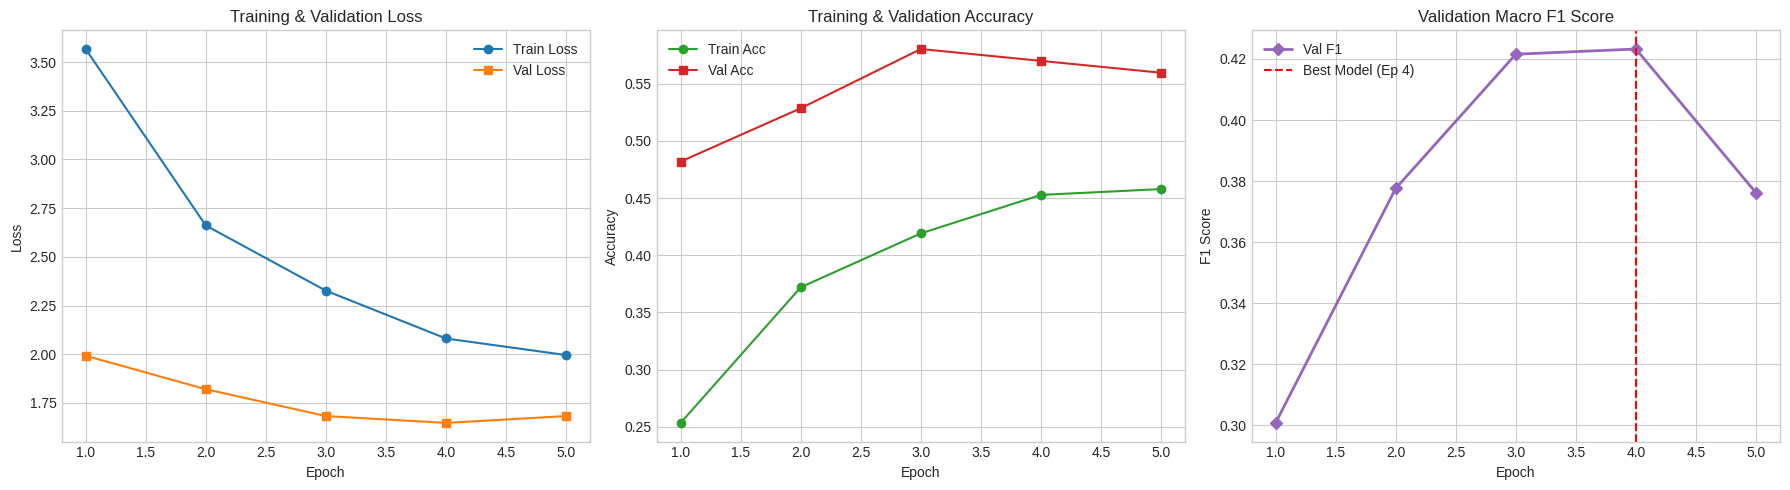

✓ Biểu đồ lịch sử đã lưu tại: /content/drive/MyDrive/ISIC_2018/outputs/figures/training_history_final.png


In [16]:
# ============================================================
# CELL 9: Training History Visualization
# ============================================================
print("\n" + "=" * 60)
print("CELL 10: TRAINING HISTORY VISUALIZATION")
print("=" * 60)

if 'history' in locals() and len(history.get('epoch', [])) > 0:
    plt.style.use('seaborn-v0_8-whitegrid') # Làm biểu đồ đẹp hơn
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Đồ thị Loss (Học máy tốt là Loss giảm dần)
    axes[0].plot(history['epoch'], history['train_loss'], label='Train Loss', marker='o', color='#1f77b4')
    axes[0].plot(history['epoch'], history['val_loss'], label='Val Loss', marker='s', color='#ff7f0e')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend()

    # Đồ thị Accuracy
    axes[1].plot(history['epoch'], history['train_acc'], label='Train Acc', marker='o', color='#2ca02c')
    axes[1].plot(history['epoch'], history['val_acc'], label='Val Acc', marker='s', color='#d62728')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training & Validation Accuracy')
    axes[1].legend()

    # Đồ thị F1 Score (Chỉ số đánh giá độ vượt trội)
    axes[2].plot(history['epoch'], history['val_f1'], label='Val F1', color='#9467bd', marker='D', linewidth=2)
    if 'best_epoch' in locals() and best_epoch > 0:
        axes[2].axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Ep {best_epoch})')

    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_title('Validation Macro F1 Score')
    axes[2].legend()

    plt.tight_layout()
    history_img_path = os.path.join(DIR_FIGURES, 'training_history_final.png')
    plt.savefig(history_img_path, dpi=200)
    plt.show()
    print(f"✓ Biểu đồ lịch sử đã lưu tại: {history_img_path}")
else:
    print("⚠ Cảnh báo: Biến 'history' trống. Hãy chạy Cell 8 trước để load history từ checkpoint.")

Đang dự đoán 12 ảnh từ tập Test...


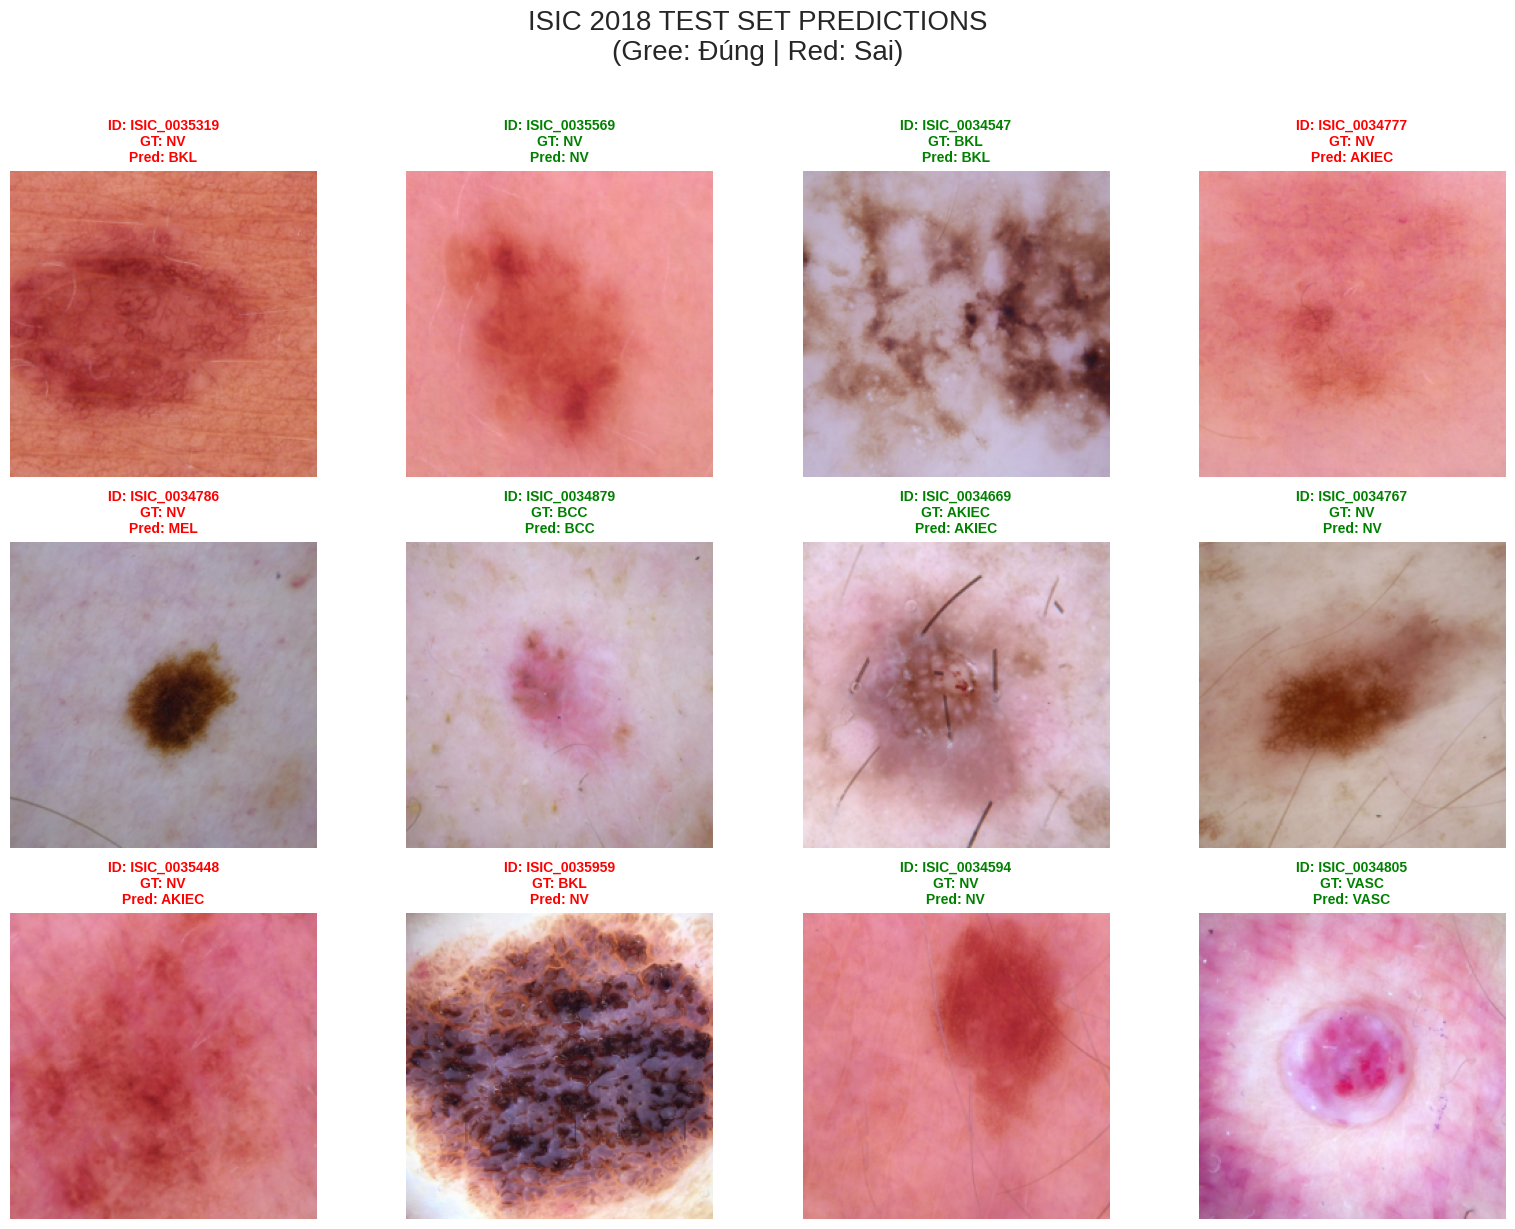

In [22]:
# cell 11: Dự đoán ảnh
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_test_results(model, dataset, device, idx2label, num_images=6):
    model.eval()

    num_images = min(num_images, len(dataset))
    indices = np.random.choice(len(dataset), num_images, replace=False)

    cols = 4
    rows = math.ceil(num_images / cols)

    plt.figure(figsize=(4 * cols, 4 * rows))

    # Thông số chuẩn ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    print(f"Đang dự đoán {num_images} ảnh từ tập Test...")

    for i, idx in enumerate(indices):
        # image, label (tensor), image_id
        image, label, image_id = dataset[idx]

        input_img = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_img)
            pred = torch.argmax(output, dim=1).item()

        img = image.permute(1, 2, 0).cpu().numpy()
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

        # SỬA LỖI TẠI ĐÂY: Dùng label.item() để chuyển tensor sang int
        true_label_idx = label.item()
        is_correct = (true_label_idx == pred)

        title_color = "green" if is_correct else "red"

        gt_name = idx2label[true_label_idx]
        pred_name = idx2label[pred]

        plt.title(
            f"ID: {image_id}\nGT: {gt_name}\nPred: {pred_name}",
            color=title_color,
            fontsize=10,
            fontweight='bold'
        )

    plt.suptitle("ISIC 2018 TEST SET PREDICTIONS\n(Gree: Đúng | Red: Sai)", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

# Gọi hàm hiển thị
visualize_test_results(
    model,
    test_dataset,
    DEVICE,
    idx2label,
    num_images=12
)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Focal Loss giúp tập trung vào các mẫu khó học (Hard examples)
    và giảm nhẹ ảnh hưởng của các mẫu dễ (như nốt ruồi thông thường - NV).
    """
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Tính Cross Entropy cơ bản
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss) # Xác suất dự đoán đúng cho mẫu đó

        # Công thức Focal Loss: FL = alpha * (1 - pt)^gamma * CE
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        return focal_loss.sum()

In [28]:
# ============================================================
# CELL 12: Chạy giai đoạn 2
# ============================================================
import config
import importlib
from model import unfreeze_backbone_layers, print_model_info, load_checkpoint
from train import get_optimizer, get_scheduler

importlib.reload(config)

# 1. Nạp lại mô hình tại mốc Epoch 5 để đảm bảo không bị mất dữ liệu vừa train
checkpoint = load_checkpoint(model, optimizer, config.MODEL_PATH, DEVICE)
start_epoch = checkpoint.get('epoch', 5)

# 2. Cài đặt mục tiêu dừng lại ở Epoch 6
NEW_TOTAL_EPOCHS = 6
remaining_epochs = NEW_TOTAL_EPOCHS - start_epoch

if remaining_epochs <= 0:
    print(f"✅ Đã đủ {start_epoch} Epoch. Bạn có thể làm báo cáo ngay!")
else:
    print(f"🔄 Đang ở Epoch {start_epoch}. Sẽ chạy nốt {remaining_epochs} Epoch cuối.")

    # 3. Giữ nguyên cấu hình Fine-tuning
    unfreeze_backbone_layers(model, num_layers=-1)
    optimizer = get_optimizer(model, lr=1e-5, weight_decay=config.WEIGHT_DECAY)
    scheduler = get_scheduler(optimizer, num_epochs=remaining_epochs)
    criterion = FocalLoss(gamma=2.0)

    # 4. Chạy Training nốt vòng cuối
    model, history, best_val_f1, best_epoch = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        num_epochs=remaining_epochs,
        device=DEVICE,
        config_dict=cfg_dict,
        start_epoch=start_epoch,
        best_val_f1=best_val_f1,
        best_epoch=best_epoch,
        history=history
    )

✓ Running on Google Colab
✓ Drive Root: /content/drive/MyDrive/ISIC_2018
Loading checkpoint from: /content/drive/MyDrive/ISIC_2018/outputs/models/efficientnet_b1_isic2018.pt
✓ Loaded checkpoint from epoch 5, best F1: 0.5284
🔄 Đang ở Epoch 5. Sẽ chạy nốt 1 Epoch cuối.
✓ All layers unfrozen for fine-tuning
Optimizer: AdamW (lr=1e-05, weight_decay=0.001)
  Optimizing 6,522,151 / 6,522,151 parameters (100.0%)
Scheduler: CosineAnnealingLR (T_max=1)
Training for 1 epochs (from 5 to 6)

Epoch 6/6


Training:   0%|          | 0/626 [00:00<?, ?it/s]

 Train Loss: 0.8228 | Train Acc: 0.6146
 Running validation...
 Val Loss: 0.6078 | Val Acc: 0.6943 | Val F1: 0.5844
New best model! F1: 0.5844
✓ Checkpoint saved: /content/drive/MyDrive/ISIC_2018/outputs/models/efficientnet_b1_isic2018.pt

 Training Stage Complete!
 Best: Epoch 6 | F1: 0.5844


In [29]:
# ============================================================
# CELL 8 part 2: Evaluate on Validation Set
# ============================================================
print("\n" + "=" * 60)
print("CELL 8: EVALUATE ON VALIDATION SET")
print("=" * 60)

# 1. Load best model và nạp lại History
print(f"Loading best model from: {MODEL_PATH}")
# Đảm bảo nạp history từ checkpoint để vẽ biểu đồ ở Cell 10
checkpoint = load_checkpoint(model, None, MODEL_PATH, DEVICE)
if 'history' in checkpoint:
    history = checkpoint['history']
    print(f"✓ Đã khôi phục lịch sử huấn luyện ({len(history['epoch'])} epochs)")

# 2. Chạy đánh giá
print("\nEvaluating on validation set...")
val_loss, val_acc, val_f1, val_bal_acc, val_preds, val_labels, val_probs, val_image_ids = evaluate(
    model, val_loader, criterion, DEVICE, use_tta=USE_TTA_VALIDATION
)

# 3. Hiển thị kết quả dạng số
print(f"\n📊 Validation Results (Epoch {checkpoint.get('epoch', 'N/A')}):")
print(f"  ● Loss: {val_loss:.4f}")
print(f"  ● Accuracy (Raw): {val_acc:.4f}")
print(f"  ● Balanced Accuracy: {val_bal_acc:.4f}")
print(f"  ● Macro F1-Score: {val_f1:.4f}  <-- Chỉ số quan trọng nhất")

# 4. Trực quan hóa Confusion Matrix
# Lưu ý: Confusion Matrix giúp bạn biết mô hình đang nhầm lẫn ở đâu (Ví dụ: nhầm Melanoma sang NV)
plot_confusion_matrix(
    val_labels, val_preds, idx2label,
    save_path=os.path.join(DIR_FIGURES, 'val_confusion_matrix.png'),
    title=f'Validation Confusion Matrix (Epoch {checkpoint.get("epoch")})'
)
plt.show()

# 5. In báo cáo chi tiết từng lớp (Precision, Recall, F1 cho từng loại bệnh)
report = print_classification_report(val_labels, val_preds, idx2label)


CELL 8: EVALUATE ON VALIDATION SET
Loading best model from: /content/drive/MyDrive/ISIC_2018/outputs/models/efficientnet_b1_isic2018.pt
Loading checkpoint from: /content/drive/MyDrive/ISIC_2018/outputs/models/efficientnet_b1_isic2018.pt
✓ Loaded checkpoint from epoch 6, best F1: 0.5844
✓ Đã khôi phục lịch sử huấn luyện (7 epochs)

Evaluating on validation set...

📊 Validation Results (Epoch 6):
  ● Loss: 0.6078
  ● Accuracy (Raw): 0.6943
  ● Balanced Accuracy: 0.7217
  ● Macro F1-Score: 0.5844  <-- Chỉ số quan trọng nhất
✓ Confusion matrix saved: /content/drive/MyDrive/ISIC_2018/outputs/figures/val_confusion_matrix.png

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       AKIEC     0.2857    0.5000    0.3636         8
         BCC     0.4500    0.6000    0.5143        15
         BKL     0.4615    0.5455    0.5000        22
          DF     0.3333    1.0000    0.5000         1
         MEL     0.4118    0.6667    0.5091        21
          NV    


CELL 10: TRAINING HISTORY VISUALIZATION


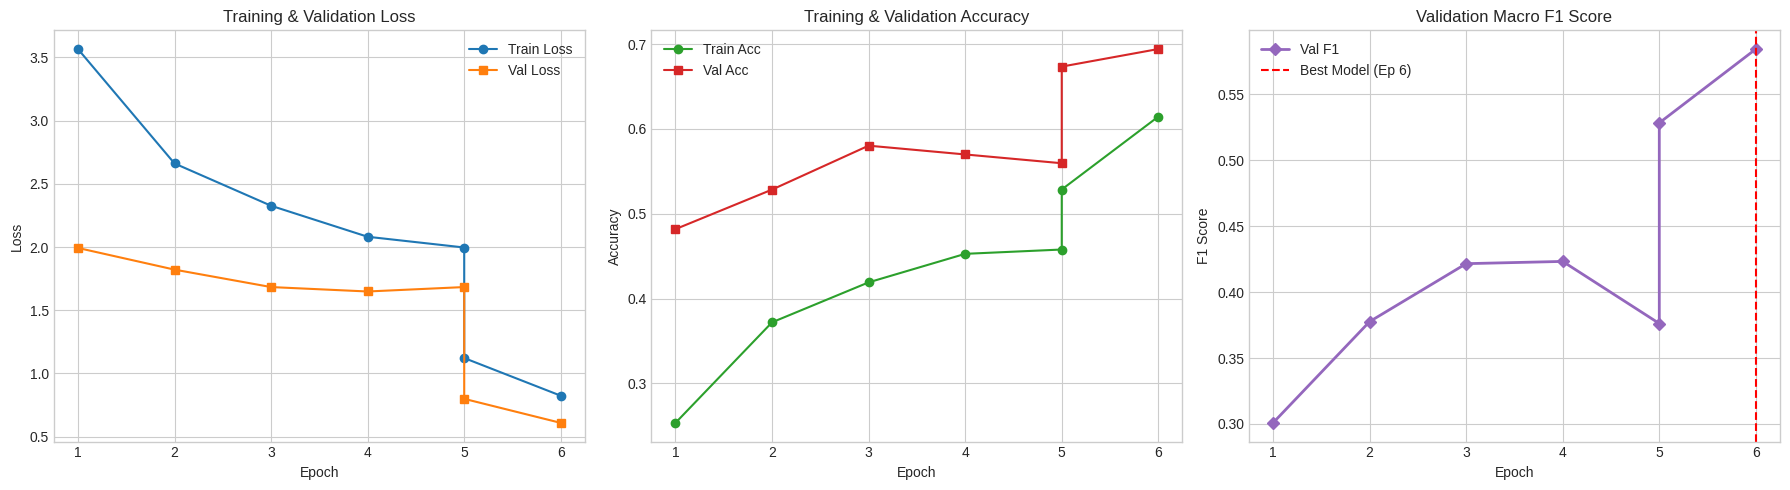

✓ Biểu đồ lịch sử đã lưu tại: /content/drive/MyDrive/ISIC_2018/outputs/figures/training_history_final.png


In [30]:
# ============================================================
# CELL 9 part 2: Training History Visualization
# ============================================================
print("\n" + "=" * 60)
print("CELL 10: TRAINING HISTORY VISUALIZATION")
print("=" * 60)

if 'history' in locals() and len(history.get('epoch', [])) > 0:
    plt.style.use('seaborn-v0_8-whitegrid') # Làm biểu đồ đẹp hơn
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Đồ thị Loss (Học máy tốt là Loss giảm dần)
    axes[0].plot(history['epoch'], history['train_loss'], label='Train Loss', marker='o', color='#1f77b4')
    axes[0].plot(history['epoch'], history['val_loss'], label='Val Loss', marker='s', color='#ff7f0e')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend()

    # Đồ thị Accuracy
    axes[1].plot(history['epoch'], history['train_acc'], label='Train Acc', marker='o', color='#2ca02c')
    axes[1].plot(history['epoch'], history['val_acc'], label='Val Acc', marker='s', color='#d62728')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training & Validation Accuracy')
    axes[1].legend()

    # Đồ thị F1 Score (Chỉ số đánh giá độ vượt trội)
    axes[2].plot(history['epoch'], history['val_f1'], label='Val F1', color='#9467bd', marker='D', linewidth=2)
    if 'best_epoch' in locals() and best_epoch > 0:
        axes[2].axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Ep {best_epoch})')

    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_title('Validation Macro F1 Score')
    axes[2].legend()

    plt.tight_layout()
    history_img_path = os.path.join(DIR_FIGURES, 'training_history_final.png')
    plt.savefig(history_img_path, dpi=200)
    plt.show()
    print(f"✓ Biểu đồ lịch sử đã lưu tại: {history_img_path}")
else:
    print("⚠ Cảnh báo: Biến 'history' trống. Hãy chạy Cell 8 trước để load history từ checkpoint.")

Đang dự đoán 12 ảnh từ tập Test...


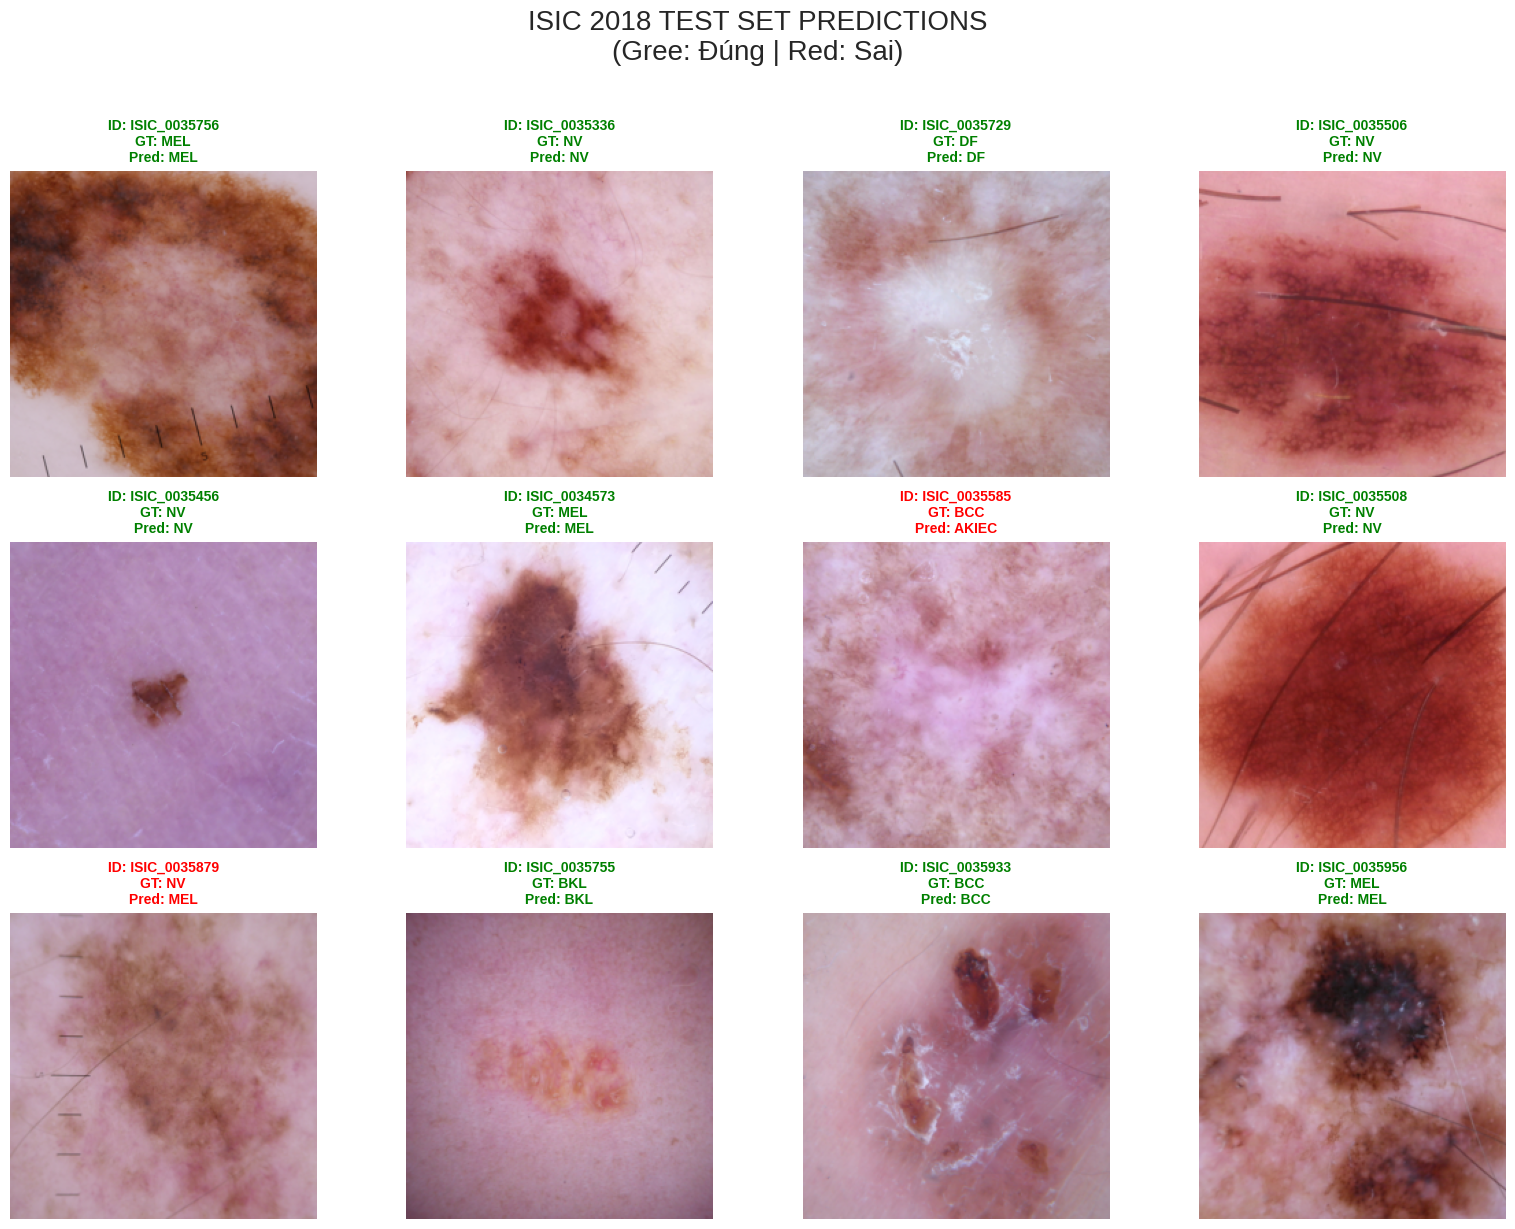

In [31]:
# cell 11: Dự đoán ảnh
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_test_results(model, dataset, device, idx2label, num_images=6):
    model.eval()

    num_images = min(num_images, len(dataset))
    indices = np.random.choice(len(dataset), num_images, replace=False)

    cols = 4
    rows = math.ceil(num_images / cols)

    plt.figure(figsize=(4 * cols, 4 * rows))

    # Thông số chuẩn ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    print(f"Đang dự đoán {num_images} ảnh từ tập Test...")

    for i, idx in enumerate(indices):
        # image, label (tensor), image_id
        image, label, image_id = dataset[idx]

        input_img = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_img)
            pred = torch.argmax(output, dim=1).item()

        img = image.permute(1, 2, 0).cpu().numpy()
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

        # SỬA LỖI TẠI ĐÂY: Dùng label.item() để chuyển tensor sang int
        true_label_idx = label.item()
        is_correct = (true_label_idx == pred)

        title_color = "green" if is_correct else "red"

        gt_name = idx2label[true_label_idx]
        pred_name = idx2label[pred]

        plt.title(
            f"ID: {image_id}\nGT: {gt_name}\nPred: {pred_name}",
            color=title_color,
            fontsize=10,
            fontweight='bold'
        )

    plt.suptitle("ISIC 2018 TEST SET PREDICTIONS\n(Gree: Đúng | Red: Sai)", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

# Gọi hàm hiển thị
visualize_test_results(
    model,
    test_dataset,
    DEVICE,
    idx2label,
    num_images=12
)


CELL 13: TEST SET EVALUATION (STAGE 2 COMPLETE)
🚀 Đang quét 1512 ảnh tập Test...

✅ KẾT QUẢ CUỐI CÙNG:
  ● Accuracy: 0.6561
  ● Balanced Accuracy: 0.6383


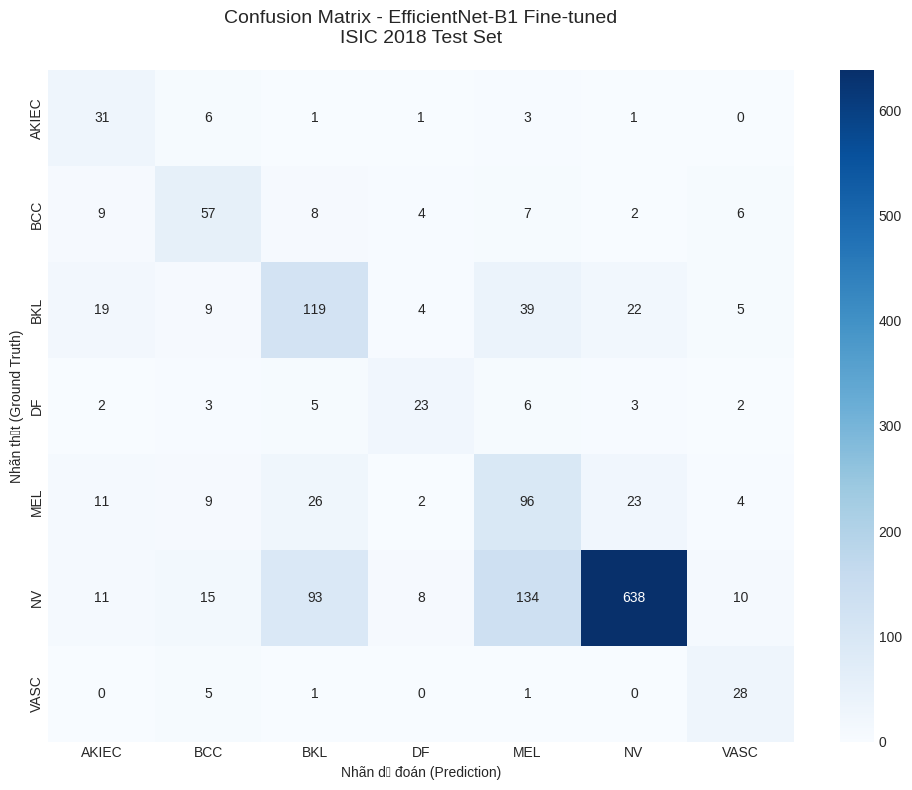


📋 PHÂN TÍCH CHI TIẾT TỪNG LỚP (Classification Report):
              precision    recall  f1-score   support

       AKIEC       0.37      0.72      0.49        43
         BCC       0.55      0.61      0.58        93
         BKL       0.47      0.55      0.51       217
          DF       0.55      0.52      0.53        44
         MEL       0.34      0.56      0.42       171
          NV       0.93      0.70      0.80       909
        VASC       0.51      0.80      0.62        35

    accuracy                           0.66      1512
   macro avg       0.53      0.64      0.56      1512
weighted avg       0.73      0.66      0.68      1512



In [33]:
# ============================================================
# CELL 13: FINAL TEST EVALUATION & CONFUSION MATRIX
# ============================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from torch.utils.data import DataLoader
import os

# --- HÀM VẼ CONFUSION MATRIX TRỰC TIẾP ---
def plot_final_cm(y_true, y_pred, classes, save_path, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=14, pad=20)
    plt.ylabel('Nhãn thật (Ground Truth)')
    plt.xlabel('Nhãn dự đoán (Prediction)')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

print("\n" + "=" * 60)
print("CELL 13: TEST SET EVALUATION (STAGE 2 COMPLETE)")
print("=" * 60)

# 1. Đánh giá mô hình
model.eval()
all_preds = []
all_labels = []

test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

print(f"🚀 Đang quét {len(test_dataset)} ảnh tập Test...")
with torch.no_grad():
    for images, labels, _ in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2. Tính toán chỉ số
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()
test_bal_acc = balanced_accuracy_score(all_labels, all_preds)

print(f"\n✅ KẾT QUẢ CUỐI CÙNG:")
print(f"  ● Accuracy: {test_acc:.4f}")
print(f"  ● Balanced Accuracy: {test_bal_acc:.4f}")

# 3. Vẽ và lưu Confusion Matrix
classes = [idx2label[i] for i in range(len(idx2label))]
test_cm_path = os.path.join(DIR_FIGURES, 'final_test_confusion_matrix.png')

plot_final_cm(
    all_labels, all_preds, classes,
    save_path=test_cm_path,
    title=f'Confusion Matrix - EfficientNet-B1 Fine-tuned\nISIC 2018 Test Set'
)

# 4. In báo cáo chi tiết để đưa vào phụ lục
print("\n📋 PHÂN TÍCH CHI TIẾT TỪNG LỚP (Classification Report):")
print(classification_report(all_labels, all_preds, target_names=classes))